# Importing libraries and data

In [3]:
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np

np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#for gan...
!pip install visualkeras
import visualkeras

import imageio
from PIL import Image
from IPython.display import display
import seaborn as sns
import warnings
import logging

from tqdm import tqdm

!pip install tensorflow_addons
import tensorflow_addons
import math
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tqdm.notebook import tqdm
# from wandb.keras import WandbCallback
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import losses
import time

tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()

import copy
def add_noise(cop):
    imagee = copy.copy(cop)
    var = random.randint(0, 1)
    if var == 1:     
        '''Add random noise to an image'''
        imagee = imagee/255
        VARIABILITY = 0.02
        deviation = VARIABILITY
        noise = np.random.normal(0, deviation, imagee.shape)
        imagee += noise
        # np.clip(img, 0., 255.)
        # return imagee*255
    # else:
        imagee = imagee*255
        lista = [10, 20, 25, 30, 35]

        l = random.choice(lista)
        box = np.zeros(l**2).reshape(l, l)
        xx, yy = np.random.randint(0,95-l, size=2)
        for i in range(3):
            imagee[xx:xx+l, yy:yy+l, i] = box

        return imagee
    else:
        return imagee
    
def orthogonal_rot(cop):
    imagee = copy.copy(cop)
    return np.rot90(imagee, np.random.choice([-1, 0, 1]))

    

2.13.0


In [5]:
import time
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
class LR_ASK(tf.keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.75): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor
        
    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to' 
            print(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started
       
    def on_train_end(self, logs=None):   # runs at the end of training  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print(msg)
        model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100 
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0 
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1            
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print(msg) # green foreground
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print(msg) # yellow foreground
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                model.set_weights(self.best_weights) # set the weights of the model to the best weights      
                
        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print(msg) # cyan foreground
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print(msg) # cyan foreground
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print(msg) # cyan foreground
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print(msg) # cyan foreground
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print(msg) # cyan foreground

In [4]:


# Load images from the 'items/' folder
temp = np.load('public_data.npz', allow_pickle = True)
img = temp["data"]
label = temp["labels"]
  # Normalize image pixel values to a float range [0, 1]
img = (img).astype(np.float32)

# set 0,1 label
for i in range(len(label)):
    if(label[i] == 'healthy'):
        label[i] = 0
    else:
        label[i] = 1

# cleaning images from trol and shrek
ref_img = img[58]
ref_img2 = img[2150]
c = 0
c2 = 0
rm_indexes = []
rm2_indexes = []
for i in range(0, len(img)):
    deviation = np.mean(np.abs(ref_img - img[i]))
    deviation2 = np.mean(np.abs(ref_img2 - img[i]))
    if(deviation == 0.0):
        #print(i)
        c += 1
        rm_indexes.append(i)
    elif(deviation2 == 0.0):
        c2 += 1
        rm2_indexes.append(i)

clean_img = np.delete(img, rm_indexes + rm2_indexes, axis=0)
clean_label = np.delete(label, rm_indexes + rm2_indexes, axis=0)


#DATA AUGMENTATION TO BALANCE CLASSES!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Create an instance of ImageDataGenerator
datagen = ImageDataGenerator(
    # rotation_range=20,
    # shear_range=[0.3, 0.7],
#     zoom_range=[0.3, 0.9],
    horizontal_flip=True,
    vertical_flip=True,
    # brightness_range=[0, 0.7],
    fill_mode='nearest',
    preprocessing_function = orthogonal_rot
)

# Reshape the numpy array to fit the requirements of the flow method
x = clean_img[clean_label == 1]  # Replace 'your_numpy_array' with your actual numpy array

# Create a generator to augment the images
augmented_images = []
for x_batch in datagen.flow(x, batch_size=1, seed=42, shuffle=False):
    augmented_images.append(x_batch[0])
    if len(augmented_images) >= 1198:
        break

# Convert the list of augmented images to a numpy array
augmented_images_array = np.array(augmented_images)

clean_img = np.append(clean_img, augmented_images_array, axis = 0)
clean_label = np.append(clean_label, np.ones(1198))
print(clean_img.shape)
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


# Concatenate 'animals' and 'items' arrays along axis 0
X = clean_img
# Create labels: 1 for 'animals', 0 for 'items'
y = clean_label

y = tfk.utils.to_categorical(y, 2) #one hot encodi

# Split data into train_val and test sets
#X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=1000, stratify=np.argmax(y,axis=1))
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=.15, stratify=np.argmax(y,axis=1))

# Further split train_val into train and validation sets
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=1000, stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
#print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


# Explain
# def getSamplesFromDataGen(resultData):
#     x = resultData.next() #fetch the first batch
#     a = x[0] # train data
#     b = x[1] # train label
#     for i in range(0,5):
#         plt.imshow(a[i])
#         plt.title(b[i])
#         plt.show()
BATCH_SIZE = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # train generator with augmentation
train_image_gen  = ImageDataGenerator(rotation_range=20, #maybe better not to rotate??
                                      width_shift_range=0.1,
                                      height_shift_range=0.1,
                                      zoom_range=[0.5, 0.9],
                                      shear_range=0.2,
                                      brightness_range = [0.5, 1.5],
                                      # vertical_flip=True,
                                      # horizontal_flip=True,
                                      fill_mode='nearest',
#                                       validation_split = 0.15
                                      preprocessing_function=add_noise
                                      )


# validation generator without augmentation
# validation_image_gen = ImageDataGenerator(validation_split = 0.15,
#                                           )

train_dataset = train_image_gen.flow(x = X_train, y = y_train, seed = 42,
                                     batch_size = BATCH_SIZE)
validation_dataset = ImageDataGenerator().flow(X_val, y_val)
# validation_dataset = train_image_gen.flow(x = X, y = y, seed = 42, batch_size = BATCH_SIZE, subset = "validation")
# validation_dataset = validation_image_gen.flow(x = X, y = y, seed = 42,  subset = "validation")




(6202, 96, 96, 3)
X_train shape: (5271, 96, 96, 3), y_train shape: (5271, 2)
X_val shape: (931, 96, 96, 3), y_val shape: (931, 2)


# Data augmentation

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
HEIGHT = 96
WIDTH = 96

yy_train = np.argmax(y_train, axis = -1)
yy_val = np.argmax(y_val, axis = -1)
train_tf = tf.data.Dataset.from_tensor_slices((X_train, yy_train.astype(int)))#remove astype(int) at the end
validation_tf = tf.data.Dataset.from_tensor_slices((X_val, yy_val.astype(int)))

IMG_SHAPE = 96
BS = 128
AUTO = tf.data.experimental.AUTOTUNE

# Referred from: https://arxiv.org/pdf/2002.05709.pdf (Appendxi A
# corresponding GitHub: https://github.com/google-research/simclr/)
# I did not use all the augmentation policies proposed in the above paper

@tf.function
def custom_augment(image, label):
    # Random flips
    image = random_apply(tf.image.flip_left_right, image, p=0.4)
    image = random_apply(tf.image.flip_up_down, image, p = 0.2)
    image = random_apply(tf.image.rot90, image, p = 0.1)
#     image = random_apply(tf.image.random_crop()) #gotta resize
#     image = random_apply(crop_and_resize, image, p = 0.2)
    image = random_apply(cut_out, image, p = 0.8)
    image = random_apply(aug_shear, image, p = 0.4)
    image = random_apply(crop_img, image, p = 0.3)


    # Randomly apply transformation (color distortions) with probability p.
    image = random_apply(color_jitter, image, p=0.5)
#     image = random_apply(color_drop, image, p=0.2)
#     image = random_apply(cacca_su_img, image, p = 0.4)
    image = random_apply(tf.image.transpose, image, p = 0.5)
    return (image, label)

@tf.function
def color_jitter(x, s=0.3):
    # one can also shuffle the order of following augmentations
    # each time they are applied.
    x = tf.image.random_brightness(x, max_delta=0.8*s)
    x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_saturation(x, lower=1-0.5*s, upper=1+0.5*s)
    x = tf.image.random_hue(x, max_delta=0.2*s)
    x = tf.clip_by_value(x, 0, 1)
    return x

@tf.function
def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x

@tf.function
def cut_out(x):
  return data_augment_cutout(x)

def data_augment_cutout(image, min_mask_size=(int(HEIGHT * .1), int(HEIGHT * .1)),
                        max_mask_size=(int(HEIGHT * .125), int(HEIGHT * .125))):
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    if p_cutout > .85: # 10~15 cut outs
        n_cutout = tf.random.uniform([], 10, 15, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH,
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .6: # 5~10 cut outs
        n_cutout = tf.random.uniform([], 5, 10, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH,
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .25: # 2~5 cut outs
        n_cutout = tf.random.uniform([], 2, 5, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH,
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    else: # 1 cut out
        image = random_cutout(image, HEIGHT, WIDTH,
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image
def random_cutout(image, height, width, channels=3, min_mask_size=(10, 10), max_mask_size=(80, 80), k=1):
    assert height > min_mask_size[0]
    assert width > min_mask_size[1]
    assert height > max_mask_size[0]
    assert width > max_mask_size[1]
    for i in range(k):
      mask_height = tf.random.uniform(shape=[], minval=min_mask_size[0], maxval=max_mask_size[0], dtype=tf.int32)
      mask_width = tf.random.uniform(shape=[], minval=min_mask_size[1], maxval=max_mask_size[1], dtype=tf.int32)

      pad_h = height - mask_height
      pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
      pad_bottom = pad_h - pad_top

      pad_w = width - mask_width
      pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
      pad_right = pad_w - pad_left

      cutout_area = tf.zeros(shape=[mask_height, mask_width, channels], dtype=tf.uint8)

      cutout_mask = tf.pad([cutout_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
      cutout_mask = tf.squeeze(cutout_mask, axis=0)
      image = tf.multiply(tf.cast(image, tf.float32), tf.cast(cutout_mask, tf.float32))

    return image

@tf.function
def aug_shear(x):
  p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
  if p_shear > .5:
      x = transform_shear(x, HEIGHT, shear=20.)
  else:
      x = transform_shear(x, HEIGHT, shear=-20.)
  return x

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331

    shear = shear * tf.random.uniform([1],dtype='float32')
    shear = math.pi * shear / 180.

    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )

    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)

    # FIND ORIGIN PIXEL VALUES
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))

    return tf.reshape(d,[DIM,DIM,3])

@tf.function
def crop_img(x):
  p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
  if p_crop > .6:
    if p_crop > .85:
        x = tf.image.central_crop(x, central_fraction=.7)
    else:
        x = tf.image.central_crop(x, central_fraction=.8)
  else:
    crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
    x = tf.image.random_crop(x, size=[crop_size, crop_size, 3])
  x = tf.image.resize(x, size=[HEIGHT, WIDTH])
  return x



@tf.function
def random_apply(func, x, p):
    return tf.cond(
        tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                tf.cast(p, tf.float32)),
        lambda: func(x),
        lambda: x)

# # @tf.function
# def cacca_su_img(imageee):
#     imagee = 255*imageee.numpy()
#     lista = [20, 25, 30, 35]
#     l = random.choice(lista)
#     box = np.zeros(l**2).reshape(l, l)
#     xx, yy = np.random.randint(0,95-l, size=2)
#     for i in range(3):
#         imagee[xx:xx+l, yy:yy+l, i] = box

#     imagee = tf.convert_to_tensor(imagee)

#     return imagee/255



@tf.function
def preprocess_image(image, label):
  # image = image/255
  image = tf.image.convert_image_dtype(image, tf.float32)
  #     image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))
  image = image/255
  return (image, label)





@tf.function
def preprocess_image_class(image, label):
  image = image/255
  label = tf.one_hot()
  return (image, label)

train_tf = (
    train_tf
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(100)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BS)
    .prefetch(AUTO)
)

validation_tf = (
    validation_tf
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(100)
    .batch(BS)#BS
    .prefetch(AUTO)
)

train_tf = (train_tf.map(lambda x, y: (x, tf.one_hot(y, depth =2)))) #let's go back to categorical values
validation_tf = (validation_tf.map(lambda x, y: (x, tf.one_hot(y, depth = 2))))

In [31]:
IMG_SHAPE = 128
BS = 64
AUTO = tf.data.experimental.AUTOTUNE

# Referred from: https://arxiv.org/pdf/2002.05709.pdf (Appendxi A 
# corresponding GitHub: https://github.com/google-research/simclr/)
# I did not use all the augmentation policies proposed in the above paper
IMG_SHAPE = 128
BS = 64
# AUTO = tf.data.experimental.AUTOTUNE

# Referred from: https://arxiv.org/pdf/2002.05709.pdf (Appendxi A 
# corresponding GitHub: https://github.com/google-research/simclr/)
# I did not use all the augmentation policies proposed in the above paper

@tf.function
def custom_augment(image, label):        
    # Random flips
    image = random_apply(tf.image.flip_left_right, image, p=0.5)
    
    # Randomly apply transformation (color distortions) with probability p.
    image = random_apply(color_jitter, image, p=0.4)
    image = random_apply(color_drop, image, p=0.2)

    return (image, label)

@tf.function
def color_jitter(x, s=0.5):
    # one can also shuffle the order of following augmentations
    # each time they are applied.
    x = tf.image.random_brightness(x, max_delta=0.8*s)
    x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_hue(x, max_delta=0.2*s)
    x = tf.clip_by_value(x, 0, 1)
    return x

@tf.function
def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x

@tf.function
def random_apply(func, x, p):
    return tf.cond(
        tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                tf.cast(p, tf.float32)),
        lambda: func(x),
        lambda: x)

@tf.function
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))

    return (image, label)

# train_ds = (
#     train_ds
#     .map(preprocess_image, num_parallel_calls=AUTO)
#     .shuffle(100)
#     .map(custom_augment, num_parallel_calls=AUTO)
#     .batch(BS)
#     .prefetch(AUTO)
# )

NameError: name 'train_ds' is not defined

# Custom CNN with CBAM Architectures

In [ ]:

import keras
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras import backend as K
from keras.activations import sigmoid
from keras import layers
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import initializers
from keras.models import Sequential
def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """

    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)

    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7

    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

In [ ]:
train_batches = train_dataset
validation_batches = validation_dataset
IMG_SIZE = 96
n_classes = 2
EPOCHS = 50
BATCH_SIZE = 8
IMG_SIZE = 224
n_classes = 4
METRICS = [tfk.metrics.CategoricalAccuracy(name='accuracy'),
           tfk.metrics.Precision(name='precision'),
           tfk.metrics.Recall(name='recall'),
           tfk.metrics.AUC(name='auc')]

inp = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x1 = layers.Resizing(IMG_SIZE, IMG_SIZE)(inp)
# x2 = layers.Rescaling(1./255)(x1)
x3 = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                   padding = 'same', input_shape=(IMG_SIZE,IMG_SIZE,3))(x1)
x4 = cbam_block(x3)
x5 = layers.BatchNormalization(axis=-1)(x4)
x6 = layers.MaxPool2D(pool_size=(2, 2))(x5)
x7 = layers.Conv2D(filters=64, kernel_size=(3, 3),
                   activation='relu', padding = 'same')(x6)
x8 = cbam_block(x7)
x9 = layers.BatchNormalization(axis=-1)(x8)
x10 = layers.MaxPool2D(pool_size=(2, 2))(x9)
x11 = layers.Conv2D(filters=128, kernel_size=(3, 3),
                    activation='relu', padding = 'same')(x10)
x12 = cbam_block(x11)
x13 = layers.BatchNormalization(axis=-1)(x12)
x14 = layers.MaxPool2D(pool_size=(2, 2))(x13)
x15 = layers.Conv2D(filters=256, kernel_size=(3, 3),
                      activation='relu', padding = 'same')(x14)
x16 = cbam_block(x15)
x17 = layers.BatchNormalization(axis=-1)(x16)
x18 = layers.MaxPool2D(pool_size=(2, 2))(x17)
y1 = layers.Flatten()(x18)
y2 = layers.Dense(300, activation='relu')(y1)
y3 = layers.Dense(150, activation='relu')(y2)
y4 = layers.Dropout(0.25)(y3)
y = layers.Dense(n_classes, activation='softmax')(y4)


model = tf.keras.Model(inp, y)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=METRICS)
model.summary()

epochs=100
ask_epoch=10
ask=LR_ASK(model, epochs,  ask_epoch, factor = 0.65)
callbacks=[ask]
history=model.fit(x=train_dataset,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=validation_dataset,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

# GradCAM (code to be changed)

In [ ]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = tf.keras.Model(
        inputs=[self.model.inputs],
        outputs=[self.model.get_layer(self.layerName).output,
                 self.model.output])
        
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        image = np.asarray(image, np.float64)
        heatmap = np.asarray(heatmap, np.float64)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        return (heatmap, output)

In [ ]:
def show_heatmap(model, img_path):
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    preds = model.predict(image)
    i = np.argmax(preds[0])
    label_to_class = {'NonDemented': 0,
                      'VeryMildDemented': 1,
                      'MildDemented': 2,
                      'ModerateDemented': 3}

    class_to_label = {v: k for k, v in label_to_class.items()}

    label = class_to_label[i]
    print(f'Predicted class: {label} | Prediction probability: {max(preds[0]) * 100}%')
    
    cam = GradCAM(model, i)
    heatmap = cam.compute_heatmap(image)

    (heatmap, output) = cam.overlay_heatmap(heatmap, image[0], alpha=0.5)
    
    output = output.astype(np.uint8)
    plt.imshow(output, interpolation='nearest')
    plt.show()

Predicted class: MildDemented | Prediction probability: 86.69216632843018%


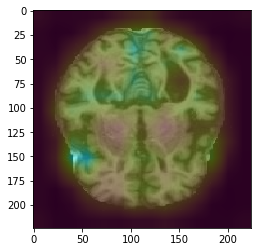

In [ ]:
img_path = "../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/MildDemented/mildDem0.jpg"
show_heatmap(model, img_path)

Predicted class: MildDemented | Prediction probability: 99.99969005584717%


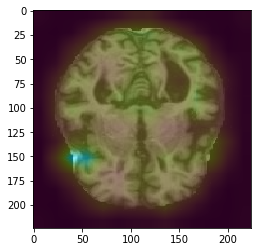

In [ ]:
img_path = "../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/MildDemented/mildDem0.jpg"
show_heatmap(model_ECA, img_path)

Predicted class: VeryMildDemented | Prediction probability: 81.06232285499573%


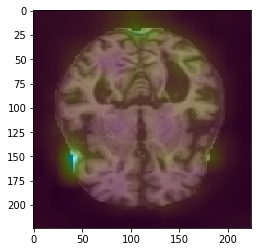

In [ ]:
img_path = "../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/MildDemented/mildDem0.jpg"
show_heatmap(model_CBAM, img_path)

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from kaggle_datasets import KaggleDatasets

import os, warnings
from sklearn import model_selection
warnings.simplefilter('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf; print(tf.__version__)
from tensorflow import keras; print(keras.__version__)
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import schedules

ModuleNotFoundError: No module named 'kaggle_datasets'

In [ ]:
class SpatialAttentionModule(keras.layers.Layer):
    def __init__(self, kernel_size=3):
        '''
        paper: https://arxiv.org/abs/1807.06521
        code: https://gist.github.com/innat/99888fa8065ecbf3ae2b297e5c10db70
        '''
        super().__init__()
        self.conv1 = keras.layers.Conv2D(64, 
                                            kernel_size=kernel_size, 
                                            use_bias=False, 
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same', 
                                            activation=tf.nn.relu)
        self.conv2 = keras.layers.Conv2D(32, kernel_size=kernel_size, 
                                            use_bias=False, 
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same', 
                                            activation=tf.nn.relu)
        self.conv3 = keras.layers.Conv2D(16, kernel_size=kernel_size, 
                                            use_bias=False, 
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same', 
                                            activation=tf.nn.relu)
        self.conv4 = keras.layers.Conv2D(1, 
                                            kernel_size=(1, 1),  
                                            use_bias=False,
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same', 
                                            activation=tf.math.sigmoid)

    def call(self, inputs):
        avg_out = tf.reduce_mean(inputs, axis=3)
        max_out = tf.reduce_max(inputs,  axis=3)
        x = tf.stack([avg_out, max_out], axis=3) 
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.conv4(x)
# A custom layer
class ChannelAttentionModule(keras.layers.Layer):
    def __init__(self):
        '''paper: https://arxiv.org/abs/1807.06521
        code: https://gist.github.com/innat/99888fa8065ecbf3ae2b297e5c10db70
        '''
        super(ChannelAttentionModule, self).__init__()
        self.ratio = ratio
        self.gapavg = keras.layers.GlobalAveragePooling2D()
        self.gmpmax = keras.layers.GlobalMaxPooling2D()
        
    def build(self, input_shape):
        self.conv2 = keras.layers.Conv2D(input_shape[-1], 
                                         kernel_size=1,
                                         strides=1, 
                                         padding='same',
                                         use_bias=False, 
                                         activation=tf.nn.elu)
        super(ChannelAttentionModule, self).build(input_shape)

    def call(self, inputs):
        # compute gap and gmp pooling 
        gapavg = self.gapavg(inputs)
        gmpmax = self.gmpmax(inputs)
        gapavg = keras.layers.Reshape((1, 1, gapavg.shape[1]))(gapavg)   
        gmpmax = keras.layers.Reshape((1, 1, gmpmax.shape[1]))(gmpmax)   
        # forward passing to the respected layers
        gapavg_out = self.conv2(gapavg)
        gmpmax_out = self.conv2(gmpmax)
        return tf.math.sigmoid(gapavg_out + gmpmax_out)
    
# A custom layer
class ChannelAttentionModule(keras.layers.Layer):
    def __init__(self):
        '''paper: https://arxiv.org/abs/1807.06521
        code: https://gist.github.com/innat/99888fa8065ecbf3ae2b297e5c10db70
        '''
        super(ChannelAttentionModule, self).__init__()
        self.ratio = ratio
        self.gapavg = keras.layers.GlobalAveragePooling2D()
        self.gmpmax = keras.layers.GlobalMaxPooling2D()
        
    def build(self, input_shape):
        self.conv2 = keras.layers.Conv2D(input_shape[-1], 
                                         kernel_size=1,
                                         strides=1, 
                                         padding='same',
                                         use_bias=False, 
                                         activation=tf.nn.elu)
        super(ChannelAttentionModule, self).build(input_shape)

    def call(self, inputs):
        # compute gap and gmp pooling 
        gapavg = self.gapavg(inputs)
        gmpmax = self.gmpmax(inputs)
        gapavg = keras.layers.Reshape((1, 1, gapavg.shape[1]))(gapavg)   
        gmpmax = keras.layers.Reshape((1, 1, gmpmax.shape[1]))(gmpmax)   
        # forward passing to the respected layers
        gapavg_out = self.conv2(gapavg)
        gmpmax_out = self.conv2(gmpmax)
        return tf.math.sigmoid(gapavg_out + gmpmax_out)
    
# Original Src: https://github.com/bfelbo/DeepMoji/blob/master/deepmoji/attlayer.py
class AttentionWeightedAverage2D(keras.layers.Layer):
    def __init__(self, **kwargs):
        self.init = keras.initializers.get('uniform')
        super(AttentionWeightedAverage2D, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [layers.InputSpec(ndim=4)]
        assert len(input_shape) == 4
        self.W = self.add_weight(shape=(input_shape[3], 1),
                                 name='{}_W'.format(self.name),
                                 initializer=self.init)
        self._trainable_weights = [self.W]
        super(AttentionWeightedAverage2D, self).build(input_shape)

    def call(self, x):
        # computes a probability distribution over the timesteps
        # uses 'max trick' for numerical stability
        # reshape is done to avoid issue with Tensorflow
        # and 2-dimensional weights
        logits  = K.dot(x, self.W)
        x_shape = K.shape(x)
        logits  = K.reshape(logits, (x_shape[0], x_shape[1], x_shape[2]))
        ai      = K.exp(logits - K.max(logits, axis=[1,2], keepdims=True))
        
        att_weights    = ai / (K.sum(ai, axis=[1,2], keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(att_weights)
        result         = K.sum(weighted_input, axis=[1,2])
        return result

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[3]
        return (input_shape[0], output_len)

In [ ]:
class RANZCRClassifier(keras.Model):
    def __init__(self, dim):
        super(RANZCRClassifier, self).__init__()
        # Defining all trainable layers in __init__ / build
        self.base  = BASE_NETS(
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
            weights='imagenet' if DEVICE == "TPU" else None, 
            include_top=False
        )
        
        # Keras Built-in
        self.batch_norm  = layers.BatchNormalization()
        self.dropout     = layers.Dropout(rate=0.5)
        
        # Neck
        self.can_module   = ChannelAttentionModule()
        self.san_module_x = SpatialAttentionModule()
        self.san_module_y = SpatialAttentionModule()
        self.awn_module   = AttentionWeightedAverage2D()
        
        # Head
        self.dense_layer = layers.Dense(512, activation=tf.nn.relu)
        self.classifier  = layers.Dense(len(SUBMIT.columns[1:]), activation='sigmoid', dtype=tf.float32)
    
    def call(self, input_tensor, training=False):
        if training is None:
            training = K.learning_phase()
            
        # Base Inputs
        base_out = self.base(input_tensor)

        # Attention Modules 1
        # Channel Attention + Spatial Attention 
        canx   = self.can_module(base_out)*base_out
        spnx   = self.san_module_x(canx)*canx
        spny   = self.san_module_y(canx)

        # Global Weighted Average Pooling
        gapx   = layers.GlobalAveragePooling2D()(spnx)
        wvgx   = layers.GlobalAveragePooling2D()(spny)
        gapavg = layers.Average()([gapx, wvgx])
        
        # Attention Modules 2
        # Attention Weighted Average (AWG)
        awgavg = self.awn_module(base_out)
        # Summation of Attentions
        attns_adds = layers.Add()([gapavg, awgavg])
        
        # Tails
        x = self.batch_norm(attns_adds)
        x = self.dense_layer(x)
        x = self.dropout(x, training=training)
        x = self.classifier(x)
        
        if not training:
            return x, base_out, canx
        return x
        
    # AFAIK: The most convenient method to print model.summary() in suclassed model
    def build_graph(self):
        x = keras.Input(shape=(IMG_SIZE, IMG_SIZE,3))
        return keras.Model(inputs=[x], outputs=self.call(x))